In [1]:
pwd

'/home/bijanadmin/Desktop/DL-modulators'

In [1]:
%matplotlib inline
import numpy as np
import torch
from torch import nn, optim
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

In [2]:
pwd

'/home/bijanadmin/Desktop/DL-modulators'

In [170]:
Sess = 15
Ch = 1
pathHit = 'Data/Hits/1_Subject/{}_Sess/{}_Ch/1_Subject_{}_Sess_{}_Ch'.format(Sess,Ch,Sess,Ch)
print(pathHit)
pathMiss = 'Data/Misses/1_Subject/{}_Sess/{}_Ch/1_Subject_{}_Sess_{}_Ch'.format(Sess,Ch,Sess,Ch)
print(pathMiss)

Data/Hits/1_Subject/15_Sess/1_Ch/1_Subject_15_Sess_1_Ch
Data/Misses/1_Subject/15_Sess/1_Ch/1_Subject_15_Sess_1_Ch


In [171]:
hitIndx = 1
fnHit = os.path.join(pathHit,"1_Subject_15_Sess_1_Ch_{}_hit.txt".format(hitIndx))
print(fnHit)

Data/Hits/1_Subject/15_Sess/1_Ch/1_Subject_15_Sess_1_Ch/1_Subject_15_Sess_1_Ch_1_hit.txt


numpy.ndarray

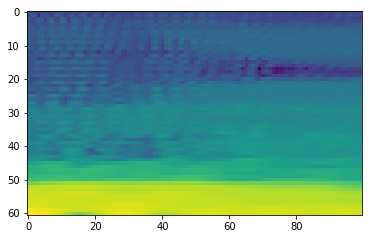

In [172]:
matrix = np.loadtxt(fnHit,dtype='f',delimiter='\t')
plt.imshow(np.flipud(matrix.transpose()))
type(matrix)

In [173]:
a = np.array([[1, 1,1],[1,1,1]])
b = np.array([[2, 2,2],[2,2,2]])
print('a dimension: ',a.shape)
print('b dimension: ',b.shape)
A = np.dstack((a, b))
print('A dimension: ',A.shape)
c = np.array([[3,3,3],[3,3,3]])
print('c dimension: ',c.shape)
B = np.dstack((A,c))
print('B dimension: ',B.shape)
print(B[:,:,0].shape)

a dimension:  (2, 3)
b dimension:  (2, 3)
A dimension:  (2, 3, 2)
c dimension:  (2, 3)
B dimension:  (2, 3, 3)
(2, 3)


### Load all the hit trials in a given electrode

In [174]:
fnHit = os.path.join(pathHit,"1_Subject_15_Sess_1_Ch_{}_hit.txt".format(1)) # name file hit (first one)
tensor_hit = np.loadtxt(fnHit,dtype='f',delimiter='\t') # load hit matrix
#plt.imshow(np.flipud(tensor_hit.transpose()))
for indx in range(2,65):
    fnHit = os.path.join(pathHit,"1_Subject_15_Sess_1_Ch_{}_hit.txt".format(indx)) # name file hit (following one)
    newmat_hit = np.loadtxt(fnHit,dtype='f',delimiter='\t') # load hit matrix
    tensor_hit = np.dstack((tensor_hit,newmat_hit)) # stack matrix along the 3rd dimension 

print(tensor_hit.shape)

(100, 61, 64)


### Load all the miss trials in a given electrode

In [149]:
fnMiss = os.path.join(pathMiss,"1_Subject_15_Sess_1_Ch_{}_miss.txt".format(1)) # name file miss (first one)
tensor_miss = np.loadtxt(fnMiss,dtype='f',delimiter='\t') # load miss matrix
for indx in range(2,45):
    fnMiss = os.path.join(pathMiss,"1_Subject_15_Sess_1_Ch_{}_miss.txt".format(indx)) # name file miss (following one)
    newmat_miss = np.loadtxt(fnMiss,dtype='f',delimiter='\t') # load hit matrix
    tensor_miss = np.dstack((tensor_miss,newmat_miss)) 
    
print(tensor_miss.shape)

(100, 61, 44)


#### Merge all the hits and misses matrices together

In [150]:
tensor_trial = np.dstack((tensor_hit,tensor_miss))
print(tensor_trial.shape)
tensor_trial[:,:,0].shape

(100, 61, 108)


(100, 61)

### Generate the labels

In [151]:
labels_hit = np.ones(64,dtype='i')
labels_miss = np.zeros(44,dtype='i')
labels_tot = np.concatenate((labels_hit,labels_miss),axis=None)
print(labels_tot)
print(labels_tot.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(108,)


In [152]:
matTorch = torch.from_numpy(matrix)
matTorch.shape

torch.Size([100, 61])

## Load data into a trainloader and testloader

In [153]:
train_data = []
for i in range(len(labels_tot)):
    train_data.append([tensor_trial[:,:,i], labels_tot[i]])

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=10)

#### Create iterable 

torch.Size([10])
torch.Size([10, 100, 61])
tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 0], dtype=torch.int32)


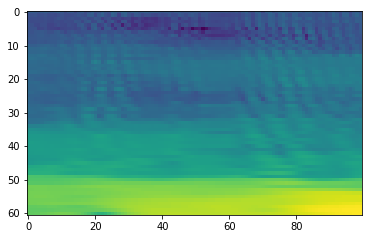

In [154]:
images, labels = next(iter(trainloader))
plt.imshow(np.flipud(images[0].numpy().transpose()))
print(labels.shape)
print(images.shape)
print(labels)

In [155]:
images.view(images.shape[0],-1).shape

torch.Size([10, 6100])

### Define the Network: Multilayer perceptron 

In [3]:
class FFN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # linear layers
        self.fc1 = nn.Linear(6100,762)
        self.fc2 = nn.Linear(762, 381)
        self.fc3 = nn.Linear(381,2)
#         self.fc5 = nn.Linear(381,2)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)    
    
    def forward(self,x):
        
        # flatten the input tensor 
        x = x.view(x.shape[0],-1)
        
        # activation functions
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
#         x = self.dropout(F.relu(self.fc3(x)))
#         x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

In [4]:
model = FFN()
model

FFN(
  (fc1): Linear(in_features=6100, out_features=762, bias=True)
  (fc2): Linear(in_features=762, out_features=381, bias=True)
  (fc3): Linear(in_features=381, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

### Set loss function and optimizer

In [5]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

#### Move model on GPU if available 

In [6]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
next(model.parameters()).is_cuda

CUDA is available!  Training on GPU ...


True

## Train and validate the Network 

In [167]:
#######################
#     TRAINING  
######################

model.train() # set the network in training mode

epochs = 20
train_losses, test_losses = [], []

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        if train_on_gpu: # move data on GPU
            images, labels = images.cuda(), labels.cuda()
            
        # flatten images into a vector
        labels = labels.long() # change label type from int to long 
        
        # Clear the gradients
        optimizer.zero_grad()
        
        log_ps = model(images) # forward pass
        loss = criterion(log_ps,labels) # compute the loss
        loss.backward() # backpropagate to compute the gradients
        optimizer.step() # update the weights
        
        running_loss =+ loss.item()
    
    else:
        
        #######################
        #     VALIDATION 
        ######################
 
        test_loss = 0
        accuracy = 0
        with torch.no_grad(): # set the tracing of gradients to zero
            model.eval() # set the dropout to OFF, i.e. model is in evaluation mode
            
            for images, labels in testloader:
                
                if train_on_gpu: # move data on GPU
                    images, labels = images.cuda(), labels.cuda()
                
                 # flatten images into a vector
                labels = labels.long() # change label type from int to long 
        
                log_ps = model(images)
                test_loss += criterion(log_ps,labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)                
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)) 
                
        model.train() # set the model back to train mode, i.e. dropout is ON
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
            
            
        ############################
        # PRINT ACCURACTY AND LOSSES
        ############################
        
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/20 Training loss: 0.056.. Test Loss: 0.677.. Test Accuracy: 0.591..
Epoch: 2/20 Training loss: 0.069.. Test Loss: 0.676.. Test Accuracy: 0.593..
Epoch: 3/20 Training loss: 0.069.. Test Loss: 0.678.. Test Accuracy: 0.586..
Epoch: 4/20 Training loss: 0.060.. Test Loss: 0.677.. Test Accuracy: 0.591..
Epoch: 5/20 Training loss: 0.056.. Test Loss: 0.676.. Test Accuracy: 0.593..
Epoch: 6/20 Training loss: 0.052.. Test Loss: 0.676.. Test Accuracy: 0.593..
Epoch: 7/20 Training loss: 0.064.. Test Loss: 0.677.. Test Accuracy: 0.589..
Epoch: 8/20 Training loss: 0.065.. Test Loss: 0.675.. Test Accuracy: 0.595..
Epoch: 9/20 Training loss: 0.061.. Test Loss: 0.675.. Test Accuracy: 0.595..
Epoch: 10/20 Training loss: 0.064.. Test Loss: 0.676.. Test Accuracy: 0.593..
Epoch: 11/20 Training loss: 0.060.. Test Loss: 0.675.. Test Accuracy: 0.595..
Epoch: 12/20 Training loss: 0.061.. Test Loss: 0.678.. Test Accuracy: 0.586..
Epoch: 13/20 Training loss: 0.056.. Test Loss: 0.675.. Test Accuracy: 0.5

In [102]:
labels

tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 0], dtype=torch.int32)

### Other tests, not relevant 

In [101]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 6100) # Test only the first image
model.cpu()
#Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)
    

#Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
print('Label: ',labels[0].numpy()) # print the label corresponding to the first image
print('Probability:  ',ps.numpy()) # print prob for 0 and 1 corresponding to the first layer

# helper.view_classify(img.view(100,61), ps)

Label:  1
Probability:   [[0.4318198  0.56818026]]


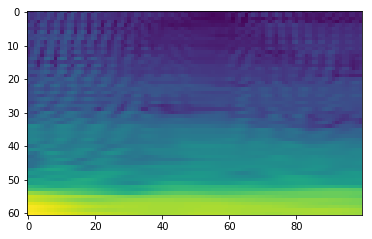

In [70]:
img.view(100,61).numpy()
plt.imshow(np.flipud(img.view(100,61).numpy().transpose()))

In [103]:
top_p, top_class = ps.topk(2, dim=1)
print(top_p)
print(top_class)
print

tensor([[0.5682, 0.4318]])
tensor([[1, 0]])


In [112]:
next(model.parameters()).is_cuda

False

In [126]:
images, labels = next(iter(trainloader))
with torch.no_grad():
    logps = model(images)
    
ps = torch.exp(logps)
print(ps)
print(labels)

tensor([[0.4565, 0.5435],
        [0.4446, 0.5554],
        [0.4643, 0.5357],
        [0.4559, 0.5441],
        [0.4648, 0.5352],
        [0.4752, 0.5248],
        [0.4576, 0.5424],
        [0.4795, 0.5205],
        [0.4576, 0.5424],
        [0.4570, 0.5430]])
tensor([1, 0, 1, 1, 0, 0, 1, 1, 0, 0], dtype=torch.int32)


In [124]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])


In [134]:
equals = top_class == labels.view(*top_class.shape)
print(equals)

tensor([[ True],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False]])


In [135]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 50.0%
